## Adversarial Examples, Feature Inversion, Recurrent Neural Networks, Image Captioning, etc

In this notebook, we will use some of the concepts behind GANs, such as input space optimization for generating adversarial examples and recovering inputs from features. There is also a section on modeling sentences with Recurrent Neural Networks. 

### 0. Loading Inceptionv3 [0pts]
First, let's load Inceptionv3, prepare the pre-processing functions, and load the imagenet class names.


In [0]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import json, io, requests, string

# Download list of 1000 categories for the ILSVRC task in right order.
!wget -nc -q http://www.cs.virginia.edu/~vicente/vision/imagenet_class_index.json
  
# Load the pre-trained model from the torchvision package.
# https://arxiv.org/abs/1512.00567  # Re-thinking the Inception Architecture.
cnn_model = models.inception_v3(pretrained = True)
cnn_model.eval();  # Set in evaluation mode! In this case it matters.

# 1. Define the appropriate image pre-processing function.
# This has to be the preprocessing function used during training. 
preprocessFn = transforms.Compose(
    [transforms.Resize(256),  # 1. Resize smallest side to 256.
     transforms.CenterCrop(224), # 2. Crop the center 224x224 pixels.
     transforms.ToTensor(), # 3. Convert to pytorch tensor.
     transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
                          std = [0.229, 0.224, 0.225])])

# 2. Load the imagenet class names.
imagenetClasses = {int(idx): entry[1] for (idx, entry) in 
                   json.load(open('imagenet_class_index.json')).items()}

# print(resnet) # It shows the network structure.
# You should instead look at source code here:
# https://pytorch.org/docs/stable/_modules/torchvision/models/inception.html#inception_v3
device = torch.device('cuda')


### 1. Adversarial Examples [5pts]


Adversarial examples are images that have been artificially modified to fool a neural network. They contain small modifications that are often not easy to see by humans, but can make deep neural networks produce arbitrary predictions. We are including here some code from the previous lab to classify the black cat from Edgar Allan Poe's Museum in Richmond using the Inceptionv3 network. 

#### 1.1 Predicting category labels for the original input image [0pts]

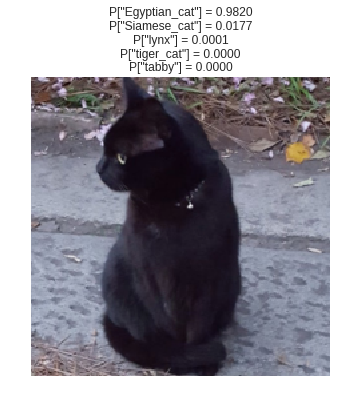

In [0]:
# Read image from URL into a PIL image type.
# This is a picture of a cat I took at the 
# Edgar Allan Poe's museum in Richmond, VA.
# Try other images!
img_url = 'http://www.cs.virginia.edu/~vicente/vision/black-cat.jpg'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))

# 1. Forward propagate the image through the CNN.
# Unsqueeze adds a dummy batch dimension needed to pass through the model.
input_img =  preprocessFn(img_pil).unsqueeze(0)
predictions = cnn_model(input_img)

# 2. Decode the top 5 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer
# outputs and not softmax scores.
probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
probs = (-probs).numpy()[0][:5]; indices = indices.numpy()[0][:10]
preds = ['P[\"' + imagenetClasses[idx] + '\"] = ' + ('%.4f' % prob) \
         for (prob, idx) in zip(probs, indices)]

# 3. Show image and predictions
def show_img_preds(input_img, preds):
  img = input_img.clone()
  plt.title('\n'.join(preds))
  # undo img transformations.
  img = img.squeeze() # get rid of batch dim.
  # un-normalize pixel values.
  for t, m, s in zip(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
    t.mul_(s).add_(m)
  plt.imshow(img.transpose(0,2).transpose(0,1)); 
  plt.grid(False); plt.axis('off');
  
show_img_preds(input_img, preds)

#### 1.2 Modifying the image to make it adversarial [5pts]

The model predicts "Egyptian cat" with a score of ~98%, in this section, your task is to make the top prediction of this model > 90% "dalmatian" by modifying the pixels on this image. Show the image (after modifications) and predictions below. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


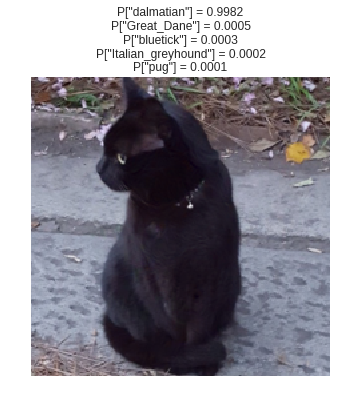

In [0]:
modified_img = input_img.clone().to(device)
targetClass = [imagenetClasses[idx] for idx in range(0, 1000)].index('dalmatian')

# 1. Modify the image to make it adversarial.
modified_img.requires_grad = True

optimizer = torch.optim.SGD([modified_img], lr = 1e-1)

# Your code goes here
from torch.autograd import Variable
cnn_model = cnn_model.to(device)
loss_fn = torch.nn.CrossEntropyLoss().to(device)
score = 0.0
target = torch.Tensor([targetClass]).long().to(device)
#modified_img = Variable(modified_img.data, requires_grad=True)
#softmax = torch.nn.LogSoftmax()
for i in range(200):
  predictions = cnn_model(modified_img)
  probs, indices = (-F.softmax(predictions, dim=1).data).sort()
  loss = loss_fn(predictions, target)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


modified_img.requires_grad = False

# 2. Forward propagate the modified image through the CNN one last time.
predictions = cnn_model(modified_img)

# 3. Decode the top 5 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer
# outputs and not softmax scores.
probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
probs = (-probs).cpu().numpy()[0][:5]; indices = indices.cpu().numpy()[0][:10]
preds = ['P[\"' + imagenetClasses[idx] + '\"] = ' + ('%.4f' % prob) \
         for (prob, idx) in zip(probs, indices)]

show_img_preds(modified_img.cpu(), preds)

### 2. Feature Inversion - Image Reconstruction from Features [5pts]

Another thing discussed during lectures for the style transfer paper "Image Style Transfer Using Convolutional Neural Networks", CVPR 2016, is the idea of reconstructing the content of an image from its features. We will provide in this section a set of features for an image, and the task is to reconstruct the image and identify the person in the picture. (Note: The image is not provided, only the features). I'm showing below the code use to compute the features.

#### 2.1 Creating a Modified Inception3 model that stores and  returns intermediate features [0pts]

In [0]:
import torch.nn as nn
from torchvision.models.inception import BasicConv2d
from torchvision.models.inception import InceptionA
from torchvision.models.inception import InceptionB
from torchvision.models.inception import InceptionC
from torchvision.models.inception import InceptionD
from torchvision.models.inception import InceptionE
from torchvision.models.inception import InceptionAux

class MyInception3(nn.Module):

    def __init__(self, num_classes=1000, aux_logits = True):
        super(MyInception3, self).__init__()
        self.aux_logits = aux_logits
        self.Conv2d_1a_3x3 = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3)
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)
        self.Mixed_6a = InceptionB(288)
        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)
        if aux_logits:
            self.AuxLogits = InceptionAux(768, num_classes)
        self.Mixed_7a = InceptionD(768)
        self.Mixed_7b = InceptionE(1280)
        self.Mixed_7c = InceptionE(2048)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        # N x 3 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        feat_1 = F.max_pool2d(x, kernel_size=3, stride=2)
        # N x 192 x 35 x 35
        x = self.Mixed_5b(feat_1)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        feat_2 = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(feat_2)
        # N x 768 x 17 x 17
        if self.training and self.aux_logits:
            aux = self.AuxLogits(x)
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 2048 x 1 x 1
        x = F.dropout(x, training=self.training)
        # N x 2048 x 1 x 1
        x = x.view(x.size(0), -1)
        # N x 2048
        x = self.fc(x)
        # N x 1000 (num_classes)
        if self.training and self.aux_logits:
            return x, aux
        return x, feat_1, feat_2
      
my_cnn_model = MyInception3(num_classes = 1000)
my_cnn_model.eval()
my_cnn_model.load_state_dict(cnn_model.state_dict())

#### 2.2 Computing Features for the Unknown.jpg input image [0pts].

In [7]:
img_url = 'http://www.cs.virginia.edu/~vicente/deeplearning/unknown.jpg'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content)).convert("RGB")

# 1. Forward propagate the image through the CNN.
# Unsqueeze adds a dummy batch dimension needed to pass through the model.
input_img =  preprocessFn(img_pil).unsqueeze(0)
predictions, feat_1, feat_2 = my_cnn_model(input_img)

print('predictions.shape', predictions.shape)
print('feat_1.shape', feat_1.shape)
print('feat_2.shape', feat_2.shape)

torch.save({'feat_1': feat_1.data, 'feat_2': feat_2.data}, 
           open('inceptionv3-features.p', 'wb'))

OSError: ignored

#### 2.3 From features to the original image [5pts].

Now, your task is to reconstruct the image in unknown.jpg using only the features obtained earlier. You don't have access to the original image, so you really can only find the identity of the person in this image by feature inversion.  We are providing you with two features computed at different levels of the Inception network, feel free to use any of them, or both. To obtain the full points for this task, you should a) Show the reconstructed image, and b) Identify the person in the reconstructed image.

0
time seconds 0.0015977780024210612


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


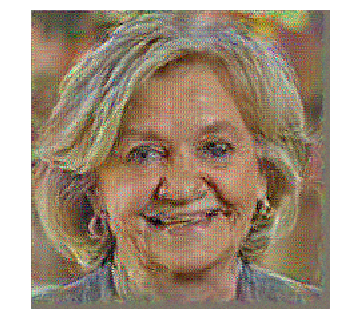

In [8]:
# Load features.
!wget -nc -q http://www.cs.virginia.edu/~vicente/deeplearning/inceptionv3-features.p
feats = torch.load('inceptionv3-features.p')
target_f1 = feats['feat_1'].to(device).detach()
target_f2 = feats['feat_2'].to(device).detach()

# Start from an image initialized with random noise.
my_input = torch.zeros(1, 3, 224, 224).normal_(0, 0.1).to(device)
my_input.requires_grad = True

# Your code goes here.
optimizer = torch.optim.SGD([my_input], lr = 1)
my_cnn_model = my_cnn_model.to(device)
loss_fn = torch.nn.MSELoss()
import time
before = time.time()
for i in range(1000):
  output, feat1, feat2 = my_cnn_model(my_input)
  loss = 1000* loss_fn(feat1, target_f1) + loss_fn(feat2, target_f2)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if i % 1000 == 0:
    print(i)
    print('time seconds', str((time.time()-before)/ 60.0))
  
my_input.requires_grad = False

# Show the image.
img = my_input.cpu().clone().squeeze()
for t, m, s in zip(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
  t.mul_(s).add_(m)
plt.imshow(img.transpose(0,2).transpose(0,1)); 
plt.grid(False); plt.axis('off');

Mary Lou Soffa

### 3. Recurrent Neural Networks (RNNs) [5pts].

Lastly, here we will experiment with Recurrent Neural Networks, for generating text. We will build a text generation model that predicts a word given the previous words, and hence will allow us to generate a sentence. This can easily be extended to generating a sentence description for a given input image. RNNs are a useful type of model for predicting sequences or handling sequences of things as inputs. In this lab we will use again Pytorch's nn library.

#### 3.1 Loading and Pre-processing [0pts]

We will also be using the COCO dataset which includes images + textual descriptions (captions) + other annotations. We can browse the dataset here: http://cocodataset.org/#home. Pytorch comes with a Dataset class for the COCO dataset but we will write our own class here. Pytorch also has a library called torchtext which does a lot of these pre-processing for us but we will not be using it -- feel free to see how to use it for your projects though. The class we will implement in this section does two important things: 1) Building a vocabulary with the most frequent words, 2) Building utilities to convert a sentence into a list of word ids, and back. We are not going to be using the images but extending the model to use images should be easy.

In [0]:
import torch, json, string
import torch.utils.data as data
import nltk # NLTK is a library for advanced processing of text.
nltk.download('punkt') # In order to tokenize sentences into words.
from nltk.tokenize import word_tokenize
from tqdm import tqdm_notebook as tqdm

class CocoCaptions(data.Dataset):
    # Load annotations in the initialization of the object.
    def __init__(self, captionsFile, vocabulary = None):
        self.data = json.load(open(captionsFile))
        self.imageIds = self.data['images']
        self.annotations = self.data['annotations']
        
        # Build a vocabulary if not provided.
        if not vocabulary:
            self.build_vocabulary()
        else:
            self.vocabulary = vocabulary
        
    # Build a vocabulary using the top 5000 words.
    def build_vocabulary(self, vocabularySize = 5000):
        # Count words, this will take a while.
        word_counter = dict()
        for annotation in tqdm(self.annotations, desc = 'Building vocabulary'):
            words = word_tokenize(annotation['caption'].lower())
            for word in words:
                word_counter[word] = word_counter.get(word, 0) + 1
                
        # Sort the words and find keep only the most frequent words.
        sorted_words = sorted(list(word_counter.items()), 
                              key = lambda x: -x[1])
        most_frequent_words = [w for (w, c) in sorted_words[:vocabularySize]]
        word2id = {w: (index + 1) for (index, w) in enumerate(most_frequent_words)}
        
        # Add a special characters for START, END sentence, and UNKnown words.
        word2id['[END]'] = 0
        word2id['[START]'] = len(word2id)
        word2id['UNK'] = len(word2id)
        id2word = {index: w for (w, index) in word2id.items()}
        self.vocabulary = {'word2id': word2id, 'id2word': id2word}
    
    # Transform a caption into a list of word ids.
    def caption2ids(self, caption):
        word2id = self.vocabulary['word2id']
        caption_ids = [word2id.get(w, word2id['UNK']) for w in word_tokenize(caption.lower())]
        caption_ids.insert(0, word2id['[START]'])
        caption_ids.append(word2id['[END]'])
        return torch.LongTensor(caption_ids)
    
    # Transform a list of word ids into a caption.
    def ids2caption(self, caption_ids):
        id2word = self.vocabulary['id2word']
        return " ".join([id2word[w.item()] for w in caption_ids])
    
    # Return imgId, and a random caption for that image.
    def __getitem__(self, index):
        annotation = self.annotations[index]
        return annotation['image_id'], self.caption2ids(annotation['caption'])
    
    # Return the number of elements of the dataset.
    def __len__(self):
        return len(self.annotations)
    
# Let's test the data class.
!wget -nc -q http://www.cs.virginia.edu/~vicente/deeplearning/captions_train2014.json
trainData = CocoCaptions('captions_train2014.json')
print('Number of training examples: ', len(trainData))

# It would be a mistake to build a vocabulary using the validation set so we reuse.
!wget -nc -q http://www.cs.virginia.edu/~vicente/deeplearning/captions_val2014.json
valData = CocoCaptions('captions_val2014.json', vocabulary = trainData.vocabulary)
print('Number of validation examples: ', len(valData))

# Print a sample from the training data.
imgId, caption = trainData[0]
print('imgId', imgId)
print('caption', caption.tolist())
print('captionString', trainData.ids2caption(caption))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Number of training examples:  414113
Number of validation examples:  100067
imgId 318556
caption [5001, 1, 141, 512, 8, 667, 415, 277, 57, 0]
captionString [START] a very clean and well decorated empty bathroom [END]


#### 3.2 Creating a custom batch-loader that supports sentences of different length [0pts]

Handling sequences is special when processing batches of inputs because each sequence can have a different length. This makes batching complicated, and different libraries have different ways of handling this which might be easier or harder to deal with. Here we are padding the sequences to the maximum sequence length in a given batch. Additionally pytorch has nice utility functions that require sorting the sequences in a batch from longest to shortest. You can look up how to use pad_packed_sequence and pack_padded_sequence in the Pytorch documentation, but we will not be using those here. We will be using here our own custom batch loader instead.

In [0]:
# The batch builder will pack all sequences of different length into a single tensor by 
# padding shorter sequences with a padding token.
def customBatchBuilder(samples):
    imgIds, captionSeqs = zip(*samples)
    
    # Sort sequences based on length.
    seqLengths = [len(seq) for seq in captionSeqs]
    maxSeqLength = max(seqLengths)
    sorted_list = sorted(zip(list(imgIds), captionSeqs, seqLengths), key = lambda x: -x[2])
    imgIds, captionSeqs, seqLengths = zip(*sorted_list)
    
    # Create tensor with padded sequences.
    paddedSeqs = torch.LongTensor(len(imgIds), maxSeqLength)
    paddedSeqs.fill_(0) # Padding token value.
    for (i, seq) in enumerate(captionSeqs):
        paddedSeqs[i, :len(seq)] = seq
    return imgIds, paddedSeqs.t(), seqLengths

# Data loaders in pytorch can use a custom batch builder, which we are using here.
trainLoader = data.DataLoader(trainData, batch_size = 10, 
                              shuffle = True, num_workers = 0,
                              collate_fn = customBatchBuilder)
valLoader = data.DataLoader(valData, batch_size = 10, 
                            shuffle = False, num_workers = 0,
                            collate_fn = customBatchBuilder)

# Now let's try using the data loader to load a batch.
index, (imgIds, paddedSeqs, seqLengths) = next(enumerate(trainLoader))
print('imgIds', imgIds)
print('paddedSequences', paddedSeqs.size())
print('seqLengths', seqLengths)

imgIds (441943, 328487, 332960, 542391, 270163, 426758, 187509, 581297, 32985, 335441)
paddedSequences torch.Size([18, 10])
seqLengths (18, 15, 14, 14, 13, 13, 12, 12, 11, 10)


#### 3.3 Creating our Recurrent Neural Network model [0pts]

We will build a model that predicts the next word based on the previous word using a recurrent neural network. Additionally we will be using an Embedding layer which will assign a unique vector to each word. The network will be trained with a softmax + negative log likelihood loss. Similar to classification we will be trying to optimize for the correct word at each time-step.

In [0]:
# By now, we should know that pytorch has a functional implementation (as opposed to class version)
# of many common layers, which is especially useful for layers that do not have any parameters.
# e.g. relu, sigmoid, softmax, etc.
import torch.nn.functional as F
import torch.nn as nn

class TextGeneratorModel(nn.Module):
    # The model has three layers: 
    #    1. An Embedding layer that turns a sequence of word ids into 
    #       a sequence of vectors of fixed size: embeddingSize.
    #    2. An RNN layer that turns the sequence of embedding vectors into 
    #       a sequence of hiddenStates.
    #    3. A classification layer that turns a sequence of hidden states into a 
    #       sequence of softmax outputs.
    def __init__(self, vocabularySize):
        super(TextGeneratorModel, self).__init__()
        # See documentation for nn.Embedding here:
        # http://pytorch.org/docs/master/nn.html#torch.nn.Embedding
        self.embedder = nn.Embedding(vocabularySize, 300)
        # Note: First dimension will be max sequence length, not batch size.
        self.rnn = nn.RNN(300, 512, batch_first = False)
        self.classifier = nn.Linear(512, vocabularySize)
        self.vocabularySize = vocabularySize

    # The forward pass makes the sequences go through the three layers defined above.
    def forward(self, paddedSeqs, initialHiddenState):
        batchSequenceLength = paddedSeqs.size(0)  # 0-dim is sequence-length-dim.
        batchSize = paddedSeqs.size(1)  # 1-dim is batch dimension.
        
        # Transform word ids into an embedding vector.
        embeddingVectors = self.embedder(paddedSeqs)
        
        # Pass the sequence of word embeddings to the RNN.
        rnnOutput, finalHiddenState = self.rnn(embeddingVectors, initialHiddenState)
        
        # Collapse the batch and sequence-length dimensions in order to use nn.Linear.
        flatSeqOutput = rnnOutput.view(-1, 512)
        predictions = self.classifier(flatSeqOutput)
        
        # Expand back the batch and sequence-length dimensions and return. 
        return predictions.view(batchSequenceLength, batchSize, self.vocabularySize), \
               finalHiddenState

# Let's test the model on some input batch.
vocabularySize = len(trainData.vocabulary['word2id'])
model = TextGeneratorModel(vocabularySize)

# Create the initial hidden state for the RNN.
index, (imgIds, paddedSeqs, seqLengths) = next(enumerate(trainLoader))
initialHiddenState = torch.Tensor(1, paddedSeqs.size(1), 512).zero_()
predictions, _ = model(paddedSeqs, initialHiddenState)

print('Here are input and output size tensor sizes:')
# Inputs are seqLength x batchSize x 1 
print('inputs', paddedSeqs.size()) # 10 input sequences.
# Outputs are seqLength x batchSize x vocabularySize
print('outputs', predictions.size()) # 10 output softmax predictions over our vocabularySize outputs.

Here are input and output size tensor sizes:
inputs torch.Size([14, 10])
outputs torch.Size([14, 10, 5003])


#### 3.4 Sampling a new sentence from the Text Generator model  [0pts]

The code below uses the RNN network as an RNN cell where we only pass one single input word, and a hidden state vector. Then we keep passing the previously predicted word, and previously predicted hidden state to predict the next word. Since the given model is not trained, it will just output a random sequence of words for now. Ideally, the trained model should also learn when to [END] a sentence.

In [0]:
import numpy as np

def sample_sentence(model, use_cuda = False):
    counter = 0
    # If the model is not trained or not properly trained, 
    # it might never end the sentence, so we put a limit.
    limit = 100 
    words = list()

    # Setup initial input state, and input word (we use "the").
    previousWord = torch.LongTensor(1, 1).fill_(trainData.vocabulary['word2id']['the'])
    previousHiddenState = torch.Tensor(1, 1, 512).zero_()
    
    if use_cuda: previousHiddenState = previousHiddenState.cuda()

    while True:
      
        # Predict the next word based on the previous hidden state and previous word.
        # We do this because we don't want the history of previousWord only its content.
        inputWord = torch.LongTensor(previousWord.data)
        
        if use_cuda: inputWord = inputWord.cuda()
          
        # Predict the logit scores for the next word.
        predictions, hiddenState = model(inputWord, previousHiddenState)
        
        # Sample from the softmax predictions.
        probabilities = F.softmax(predictions.squeeze(), dim = 0).data.cpu().numpy()
        nextWordId = np.random.multinomial(1, probabilities, 1).argmax()
        
        # Add word to the output string.
        words.append(trainData.vocabulary['id2word'][nextWordId])
        
        # Setup the inputs for the next round.
        previousWord.fill_(nextWordId)
        previousHiddenState = hiddenState

        # Keep adding words until the [END] token is generated.
        if nextWordId == trainData.vocabulary['word2id']['[END]'] or counter > limit:
            break
        counter += 1
    
    words.insert(0, 'the')
    words.insert(0, '[START]')
    return " ".join(words)

print(sample_sentence(model, use_cuda = False))

[START] the playground leaking opposing flipped college gentle gang storefront leather chalk streamers cemetery saying gap cellphones ferry sauces fountain flock china rests brushes wrapping floral aged likes shakes carrier colt refridgerator rows grassland slop stump right scooter caboose tater museum slices pad bedding bread directions waiting wallet sill lid fireworks angry spoons hot crouches says members bull tree-lined dimly boys vans mechanical grazing clothing stylized long chicken flowered setting reclining parasols dashboard rooms collared 5 rowboats formation mug avocado swings , slicing tusked nibbling thomas flipping starting waterfall elaborate pile drums installed community stoplights equipment bagel stretching selfie flames knives games dress hearts


#### 3.5 Training the Recurrent Neural Network [5pts]

Provide an implementation for the function train_rnn_model function in this section, this will be similar to the train_model function used in previous labs but you have to make sure you are providing the right input and targets for this task. We are including a figure here for illustrative purposes of how the inputs and outputs shold be arranged. Then train the model and report a few sentences generated by your model -- we will judge the correctness of your implementation mostly based on these outputs, so if your sentences look reasonable then your implementation is likely correct. Again, use the included figure as reference to make sure you are using the right inputs and targets to train the model. The loss function between predictions and targets should be nn.CrossEntropyLoss(), so you might need to collapse the batch and sequence-length dimensions before passing them to the loss function.

![alt text](http://www.cs.virginia.edu/~vicente/recognition/notebooks/rnn.png)

In [0]:
vocabularySize = len(trainData.vocabulary['word2id'])

# Create the model.
model = TextGeneratorModel(vocabularySize).cuda()

# Optimization - Usually ADAM is recommended or RMSProp.

def decodeseq(scores):
    scores = torch.transpose(scores, 0,1)
    for score in scores:
        sent = []
        for word in score:
            probabilities = F.softmax(word.squeeze(), dim = 0).data.cpu().numpy()
            nextWordId = probabilities.argmax()
            sent.append(trainData.vocabulary['id2word'][nextWordId])
        print(sent, len(sent))
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
def train_rnn_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = False):
  # Your code goes here.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0

      # Make a pass over the training data.
        model.train()
        for (i, (imgIds, paddedSeqs, seqLengths)) in enumerate(trainLoader):
            paddedSeqs = paddedSeqs.cuda()

          # Forward pass. (Prediction stage)
            hiddenState = torch.Tensor(1, paddedSeqs.size(1), 512).zero_().cuda()
            scores, hiddenState = model(paddedSeqs, hiddenState)
            
            #remove start tags
            shiftPaddSeq = paddedSeqs[1:,:]
            
            #add end layer to every input seq
            seqsEndPadding = torch.Tensor(paddedSeqs.size(1)).zero_().long().cuda().unsqueeze(0)
            shiftPaddSeq = torch.cat((shiftPaddSeq, seqsEndPadding),0)
            #flatten over batch and seq len
            flatSeqOutput = scores.view(-1, 5003)
            flatPaddedSeq = shiftPaddSeq.view(-1)
            loss = criterion(flatSeqOutput, flatPaddedSeq)
            cum_loss += loss.item()

          # Zero the gradients in the network.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:
                print(epoch, loss.item())
    return 

# Train the previously defined model.
train_rnn_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 1, use_gpu = True)

0 2.9116244316101074
0 2.793473720550537
0 3.1564347743988037
0 2.5374884605407715
0 2.7687697410583496
0 2.291755199432373
0 3.114168405532837
0 2.7895114421844482
0 2.5681917667388916
0 2.2357122898101807
0 3.185241460800171
0 2.2861828804016113
0 2.256356954574585
0 2.8424453735351562
0 1.4820362329483032
0 2.177797555923462
0 2.5459694862365723
0 2.3406291007995605
0 1.939179539680481
0 2.2008631229400635
0 2.176520347595215
0 2.312638998031616
0 2.386868476867676
0 2.4732940196990967
0 2.4509711265563965
0 2.4143295288085938
0 2.1640074253082275
0 2.655892848968506
0 2.2602920532226562
0 2.0562405586242676
0 1.8923568725585938
0 2.012495279312134
0 2.204540491104126
0 2.7754013538360596
0 2.237844705581665
0 2.5401289463043213
0 2.3205111026763916
0 2.409559726715088
0 1.831770896911621
0 2.233626365661621
0 2.3169233798980713
0 2.66058611869812
0 2.3133909702301025
0 2.6099753379821777
0 2.130622625350952
0 2.013165235519409
0 2.5363564491271973
0 2.124213457107544
0 2.6172795295

Sample some sentences:

In [0]:
# Show some sentences sampled from your model.
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))

[START] the shore , are wearing a UNK standing up in the snow . [END]
[START] the side walk at a skate park [END]
[START] the surf boards is seen with a building in the background . [END]
[START] the person performs a race swimming . [END]
[START] the head is looking down at a donut [END]
[START] the tank top of a bowl [END]
[START] the closet of a bed . [END]
[START] the top should that is standing in front of the counter . [END]
[START] the neck to a bicycle at a heavy convention . [END]
[START] the open wooden door truck is shown . [END]


In order to create an Image Captioning model that predicts a sentence given an input image as in the paper discussed during lectures: https://arxiv.org/pdf/1411.4555.pdf (Figure 3 in the paper), there is little else that needs to be done, other than inputing corresponding image features in the first time step of the RNN. This model is therefore very similar to the one implemented in this lab except that the first RNN cell gets the output of a CNN as its input. We are not implementing this for the assignment but I mention it, just in case you need to implement something like this for your course project.